In [1]:
#Add Dependencies
import pandas as pd
import numpy as np
import psycopg2 as pg
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Connection to the Postgres database and Retrive data from the tables

In [2]:
#Read Data from the PostgressSql
conn = pg.connect(user = "postgres",
                                  password = "akshaj10",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "movie_data")
sql1 = "Select * From movie_metadata;"
sql2 = "Select * from award;"
movie_df = pd.read_sql_query(sql1, conn)
award_df = pd.read_sql_query(sql2, conn)
conn = None

In [3]:
#Load Data into Pandas Data frame and Display the dataframe.
movie_df.shape

(45006, 13)

In [4]:
#Load Data into Pandas Data frame and Display the dataframe.
award_df.shape

(10395, 4)

In [5]:
#Merge the two dataframe
combined_df = pd.merge(movie_df, award_df,how='left', left_on='title', right_on='film' )
combined_df.shape

(51598, 17)

In [6]:
# Filter all rows for US as the country
movie_us_df = combined_df[combined_df['country'] == 'United States of America'] 
movie_us_df.shape

(22651, 17)

In [7]:
# Find null values
for column in movie_us_df.columns:
    print(f"Column{column} has {movie_us_df[column].isnull().sum()} null values")

Columnimdb_id has 3 null values
Columnbudget has 0 null values
Columnoriginal_title has 0 null values
Columnpopularity has 0 null values
Columnrevenue has 0 null values
Columnruntime has 5 null values
Columntitle has 0 null values
Columnvote_average has 0 null values
Columnvote_count has 0 null values
Columnproduction has 0 null values
Columncountry has 0 null values
Columnnew_genre has 0 null values
ColumnRelease_year has 2 null values
Columnindex has 15911 null values
Columncategory has 15911 null values
Columnfilm has 15911 null values
Columnwinner has 15911 null values


In [8]:
#Set the index to IMDB_ID
movie_us_df = movie_us_df.set_index("imdb_id")
movie_us_df.head()

,budget,original_title,popularity,revenue,runtime,title,vote_average,vote_count,production,country,new_genre,Release_year,index,category,film,winner
imdb_id,,,,,,,,,,,,,,,,
tt0114709,30000000,Toy Story,30000000.0,373554033.0,81.0,Toy Story,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,1995,7508.0,MUSIC (Original Musical or Comedy Score),Toy Story,False
tt0114709,30000000,Toy Story,30000000.0,373554033.0,81.0,Toy Story,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,1995,7514.0,MUSIC (Original Song),Toy Story,False
tt0114709,30000000,Toy Story,30000000.0,373554033.0,81.0,Toy Story,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,1995,7548.0,WRITING (Screenplay Written Directly for the S...,Toy Story,False
tt0113497,65000000,Jumanji,65000000.0,262797249.0,104.0,Jumanji,6.9,2413.0,TriStar Pictures,United States of America,Adventure,1995,NaN,NaN,NaN,NaN
tt0113228,0,Grumpier Old Men,0.0,0.0,101.0,Grumpier Old Men,6.5,92.0,Warner Bros.,United States of America,Romance,1995,NaN,NaN,NaN,NaN


In [9]:
columns =['budget','original_title','popularity','revenue','runtime','vote_average','vote_count','production','country','new_genre','Release_year', 'winner']

target = ['winner']

In [10]:
movie_us_df = movie_us_df.loc[:, columns].copy()
movie_us_df.shape

(22651, 12)

In [11]:
#Convert winner column into numbers 
movie_us_df["winner"] = movie_us_df["winner"].replace({True: 1, False: 0})
movie_us_df.shape

(22651, 12)

In [12]:
#Fill null values in winner column to zero 
movie_us_df["winner"] = movie_us_df["winner"].fillna(value=0)
movie_us_df.shape

(22651, 12)

In [13]:
movie_us_df['Release_year']=movie_us_df.popularity.astype('int64')

In [14]:
# Create a title Dataframe.
title_df=pd.DataFrame(data=movie_us_df['original_title'],index=movie_us_df.index,copy=True)
title_df.head()

,original_title
imdb_id,
tt0114709,Toy Story
tt0114709,Toy Story
tt0114709,Toy Story
tt0113497,Jumanji
tt0113228,Grumpier Old Men


In [15]:
# Remove the movie title from the dataframe
movie_us_df = movie_us_df.drop('original_title',1)
movie_us_df.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,production,country,new_genre,Release_year,winner
imdb_id,,,,,,,,,,,
tt0114709,30000000,30000000.0,373554033.0,81.0,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,30000000,0.0
tt0114709,30000000,30000000.0,373554033.0,81.0,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,30000000,0.0
tt0114709,30000000,30000000.0,373554033.0,81.0,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,30000000,0.0
tt0113497,65000000,65000000.0,262797249.0,104.0,6.9,2413.0,TriStar Pictures,United States of America,Adventure,65000000,0.0
tt0113228,0,0.0,0.0,101.0,6.5,92.0,Warner Bros.,United States of America,Romance,0,0.0


In [16]:
# Drop null rows
movie_us_df = movie_us_df.dropna(axis = 0,how= 'any')
movie_us_df.shape

(22646, 11)

In [17]:
# Generate our categorical variable list for movie dataset
movie_cat = movie_us_df.dtypes[movie_us_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
movie_us_df[movie_cat].nunique()

production    4610
country          1
new_genre       20
dtype: int64

### One Hot encoding production -Using top 10 values

In [18]:
# Check the production unique value counts to see if binning is required
production_counts= movie_us_df.production.value_counts()
production_counts

Other                                     2314
Paramount Pictures                        1374
Metro-Goldwyn-Mayer (MGM)                 1167
Twentieth Century Fox Film Corporation    1125
Warner Bros.                               972
                                          ... 
Independent Partners                         1
Skyra Entertainment                          1
Beat Pirate Films                            1
Five Mile River Films                        1
Brothers K Productions                       1
Name: production, Length: 4610, dtype: int64

In [19]:
# Determine which values to replace for bucketing
replace_production = list(production_counts[production_counts < 42].index)

# Replace in DataFrame
for production in replace_production:
    movie_us_df.production = movie_us_df.production.replace(production,"Other")


# Check to make sure binning was successful
movie_us_df.production.value_counts()

Other                                     12383
Paramount Pictures                         1374
Metro-Goldwyn-Mayer (MGM)                  1167
Twentieth Century Fox Film Corporation     1125
Warner Bros.                                972
Universal Pictures                          820
Columbia Pictures                           530
Columbia Pictures Corporation               480
RKO Radio Pictures                          423
United Artists                              393
Walt Disney Pictures                        287
New Line Cinema                             226
Miramax Films                               210
TriStar Pictures                            177
Orion Pictures                              121
Walt Disney Productions                     106
Touchstone Pictures                         106
Samuel Goldwyn Company, The                 105
DreamWorks SKG                               93
Universal International Pictures (UI)        89
Fox Searchlight Pictures                

In [20]:
# let's examine how many columns we will obtain after one hot encoding these variables
encode_df=pd.get_dummies(movie_us_df[movie_cat], drop_first=True)
encode_df.shape

(22646, 64)

In [21]:
# Merge one-hot encoded features and drop the originals
oscar_us_df = movie_us_df.merge(encode_df,left_index=True, right_index=True)
oscar_us_df = oscar_us_df.drop(movie_cat,1)
oscar_us_df.head(2)

,budget,popularity,revenue,runtime,vote_average,vote_count,Release_year,winner,production_Amblin Entertainment,production_American International Pictures (AIP),...,new_genre_History,new_genre_Horror,new_genre_Music,new_genre_Mystery,new_genre_Romance,new_genre_Science Fiction,new_genre_TV Movie,new_genre_Thriller,new_genre_War,new_genre_Western
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0000001,0,0.0,0.0,1.0,4.9,18.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000005,0,0.0,0.0,1.0,5.8,19.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Univariate Selection

In [22]:
# Define the features set.
X = oscar_us_df.copy()
X = X.drop('winner', axis=1)
X.shape

(52646, 71)

In [23]:
# Define the target set(output label)
y = oscar_us_df['winner']
y.head(2)

imdb_id
tt0000001    0.0
tt0000005    0.0
Name: winner, dtype: float64

In [24]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [25]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [26]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [27]:
featureScores

,Specs,Score
0,budget,3.662682e+10
1,popularity,3.662682e+10
2,revenue,7.484433e+11
3,runtime,1.997230e+04
4,vote_average,4.306883e+02
...,...,...
66,new_genre_Science Fiction,4.508282e+01
67,new_genre_TV Movie,8.316103e+00
68,new_genre_Thriller,8.680106e+01
69,new_genre_War,1.067538e+02


In [28]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                        Specs         Score
2                     revenue  7.484433e+11
0                      budget  3.662682e+10
1                  popularity  3.662682e+10
6                Release_year  3.662682e+10
5                  vote_count  4.108491e+06
3                     runtime  1.997230e+04
32           production_Other  7.293292e+02
4                vote_average  4.306883e+02
57            new_genre_Drama  2.769135e+02
45  production_United Artists  2.412986e+02


### Feature Importance

In [29]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [30]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[6.42011880e-02 6.42247741e-02 9.67032063e-02 1.42936852e-01
 1.25014628e-01 1.36870067e-01 6.29997893e-02 3.67918211e-03
 1.41513737e-04 1.28120521e-03 7.78296092e-03 6.60423735e-03
 3.43343442e-04 1.76593035e-03 6.46455964e-05 4.60975880e-04
 2.09953849e-03 8.78696631e-04 3.59585198e-04 1.69081842e-04
 1.16073349e-03 1.12946696e-03 2.24628176e-04 2.32834775e-04
 2.87014712e-03 3.72950269e-03 1.42821728e-02 8.23551799e-03
 9.72823987e-05 2.26895450e-03 1.68852633e-04 2.46495440e-03
 3.90208635e-02 1.91533898e-02 3.65520077e-03 2.14405469e-04
 4.38317086e-03 3.09187268e-03 2.70810983e-03 5.15226075e-03
 9.45443715e-05 1.19774657e-03 1.39564305e-03 1.23714385e-03
 1.39583356e-02 1.33992032e-02 5.89576918e-04 7.53488694e-03
 1.63890710e-03 2.02231650e-03 1.46132901e-03 1.08779666e-02
 1.31323209e-02 4.20524032e-03 1.17546864e-02 1.32007677e-02
 3.74308590e-03 2.73161170e-02 1.13213914e-03 2.87641484e-03
 2.62231469e-06 3.20257318e-03 4.69987029e-03 2.83000255e-03
 2.75507647e-03 4.093762

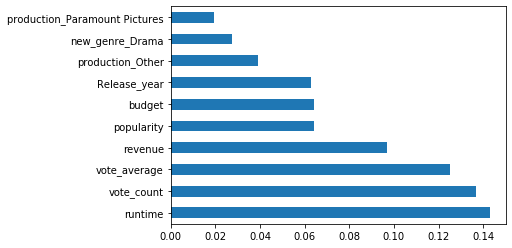

In [31]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Correlation Matrix with Heatmap

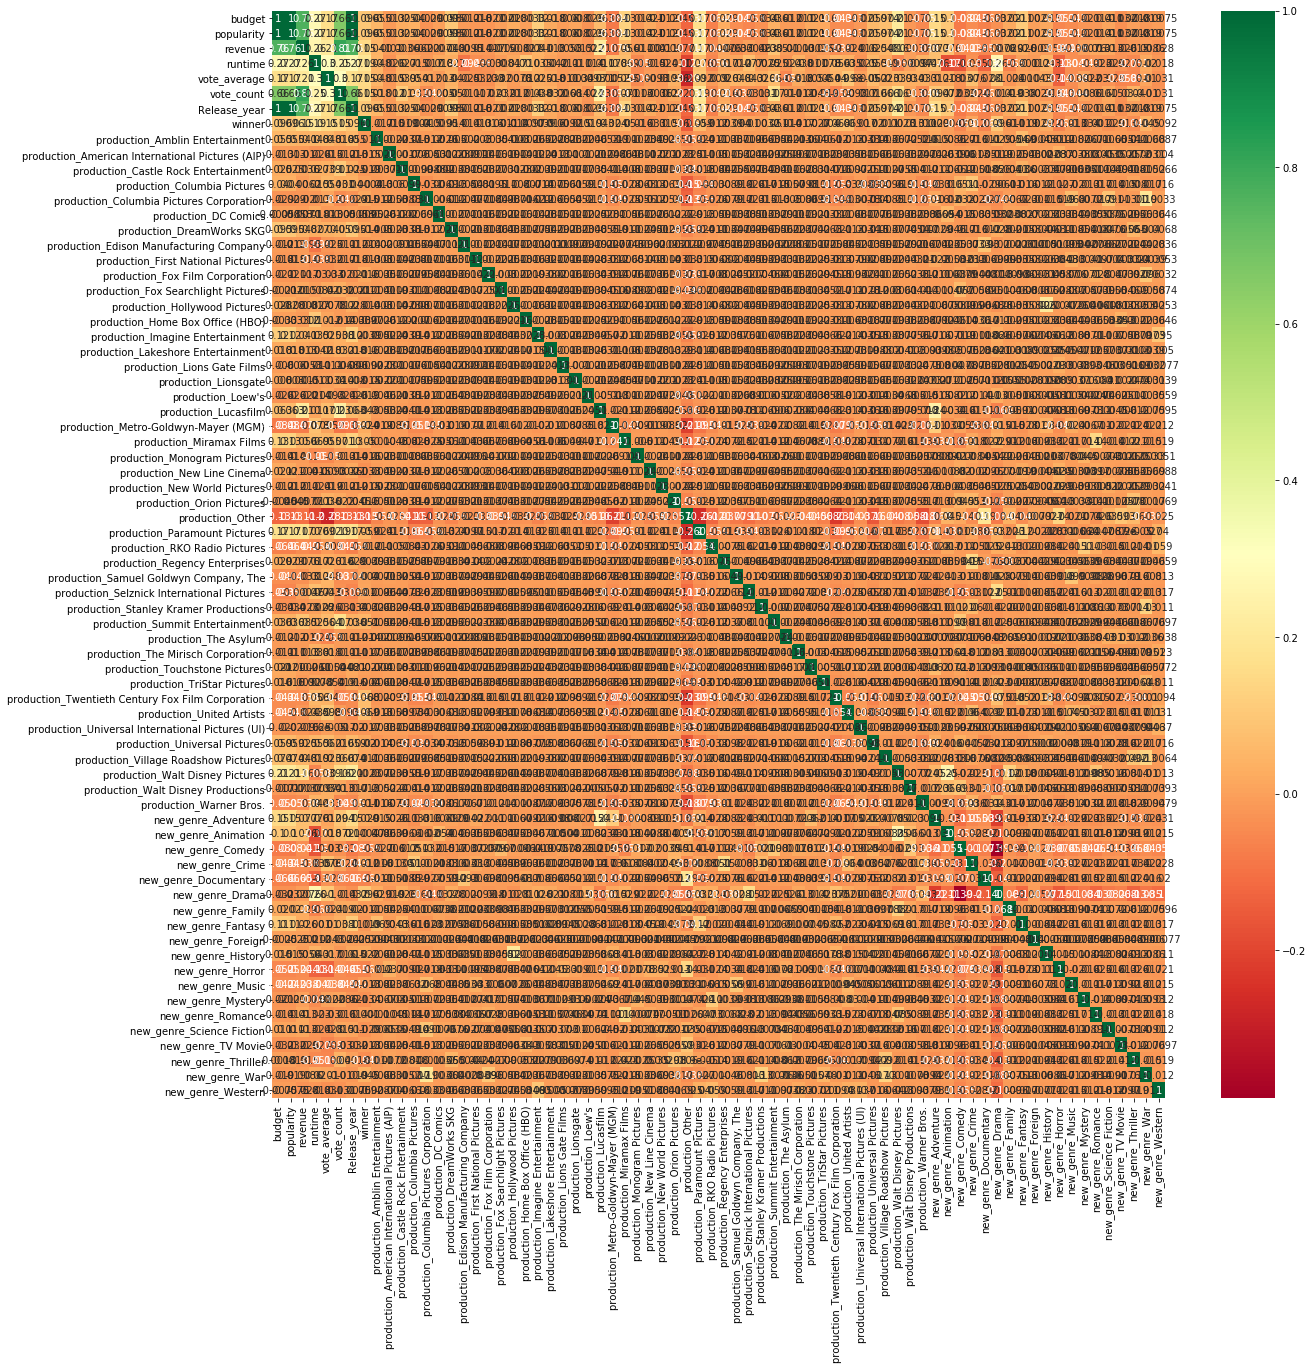

In [34]:
#get correlations of each features in dataset
corrmat = oscar_us_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(oscar_us_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
